In [ ]:
%env CUDA_VISIBLE_DEVICES=1

In [2]:
import argparse
import numpy as np
import torch
import torch.nn as nn
from torch.utils.tensorboard import SummaryWriter
import os
import json
from functools import partial
import sys
from tqdm import tqdm
import matplotlib.pyplot as plt
 
from tianshou.utils import WandbLogger
from tianshou.data import Batch, Collector, ReplayBuffer, VectorReplayBuffer
from tianshou.env import DummyVectorEnv
from tianshou.policy import BasePolicy, PPOPolicy, PGPolicy
from tianshou.trainer import OnpolicyTrainer
from tianshou.utils.net.common import ActorCritic, Net
#from tianshou.utils.net.discrete import Actor, Critic
from tianshou.utils.net.continuous import Actor, Critic, ActorProb
from tianshou.trainer.utils import gather_info, test_episode

import gymnasium as gym
from gymnasium import spaces
from gymnasium.wrappers import TimeLimit, RescaleAction, TransformObservation
from stable_baselines3.common.env_checker import check_env

from lib.environments import get_environment
from lib.environments.kolmogorov import KolmogorovEnvironment4, KolmogorovEnvironment5
from lib.policy import get_rl_algo
from lib.distributions import ElementwiseNormal
from lib.models import get_actor_critic
from lib.utils import str2bool, Config, dict_to_wandb_table, restrict_to_num_threads
from lib.trainer import MyOnpolicyTrainer
from lib.models import FcNN, MyFCNNActorProb

#temporary solution for xlb imports
sys.path.append(os.path.abspath('/home/pfischer/XLB'))
#from my_flows.kolmogorov_2d import Kolmogorov_flow
from my_flows.helpers import get_kwargs

#from lib.custom_tianshou.my_actors import MyActorProb

import wandb
wandb.require("core")

device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
def get_args() -> argparse.Namespace:
    parser = argparse.ArgumentParser()
    parser.add_argument("--task", type=str, default="CartPole-v1")
    parser.add_argument("--model", type=str, default="ppo")
    parser.add_argument("--reward_threshold", type=int, default=500)
    parser.add_argument("--seed", type=int, default=0)
    parser.add_argument("--buffer_size", type=int, default=20000)
    parser.add_argument("--max_epoch", type=int, default=10)
    parser.add_argument("--step_per_epoch", type=int, default=100)
    parser.add_argument("--train_num", type=int, default=1)
    parser.add_argument("--test_num", type=int, default=1)
    parser.add_argument("--logdir", type=str, default="log")
    parser.add_argument("--gamma", type=float, default=0.90)
    parser.add_argument("--lr", help='learning rate', type=float, default=1e-4)
    parser.add_argument("--repeat_per_collect", type=int, default=1)
    parser.add_argument("--episode_per_test", type=int, default=1)
    parser.add_argument("--batch_size", type=int, default=16)
    parser.add_argument("--step_per_collect", type=int, default=200) 
    return parser.parse_known_args()[0]


def create_env(kwargs1, kwargs2, min_a=-1., max_a=1., step_factor=10, max_t=100):
    """
    creates the environemnt and applyes wrappers to action and
    observations space and sets time limit.
    """
    env = KolmogorovEnvironment5(kwargs1, kwargs2, step_factor=step_factor, max_episode_steps=max_t)
    #env = TransformObservation(env, lambda obs: (obs/15))
    #env = TimeLimit(env, max_episode_steps=max_t)
    return env


In [4]:
#######################################################################################################
####### setup stuff *##################################################################################
#######################################################################################################
args = get_args()
# seed
np.random.seed(args.seed)
torch.manual_seed(args.seed)
#restrict_to_num_threads(1)

In [5]:
#######################################################################################################
####### environments ##################################################################################
#######################################################################################################
u0_path = "/home/pfischer/XLB/vel_init/velocity_burn_in_1806594.npy" #4096x4096 simulation
rho0_path = "/home/pfischer/XLB/vel_init/density_burn_in_1806594.npy" #4096x4096 simulation
kwargs1, T1,_,_ = get_kwargs(u0_path=u0_path, rho0_path=rho0_path, lamb=1) #cgs 
kwargs2, T2,_,_ = get_kwargs(u0_path=u0_path, rho0_path=rho0_path, lamb=1) #fgs
step_factor=10
#check if cgs time is a factor of fgs time
assert (T2%T1 == 0)
env = create_env(kwargs1, kwargs2, step_factor=step_factor,  max_t=100)
train_env = DummyVectorEnv([lambda: create_env(kwargs1, kwargs2, step_factor=step_factor, max_t=100) for _ in range(args.train_num)])
test_env = DummyVectorEnv([lambda: create_env(kwargs1, kwargs2, step_factor=step_factor, max_t=100) for _ in range(args.test_num)])
#check_env(env)

m_prime = 31232.0, end time = 31232 steps, T=355, io_rate = 64.0, Number of outputs = 490.0
m_prime = 31232.0, end time = 31232 steps, T=355, io_rate = 64.0, Number of outputs = 490.0


step=0
Correlation: 1.0
MSE: 0.0
NMSE: 0.0


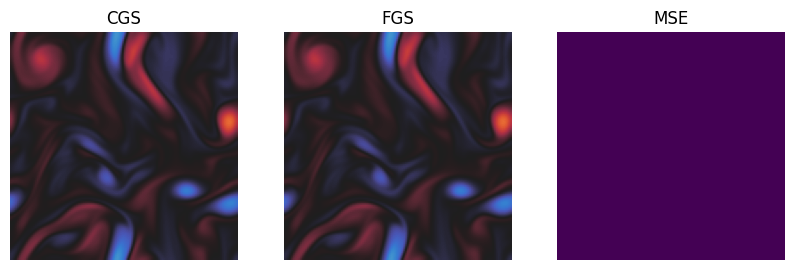

step=25
Correlation: 0.9871399410944357
MSE: 0.0016555553484021545
NMSE: 0.002381696802578409


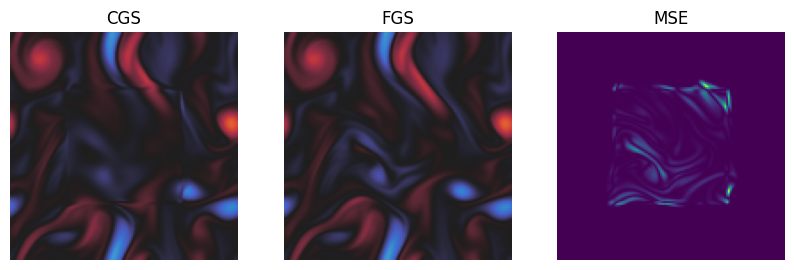

step=50
Correlation: 0.9772873312470434
MSE: 0.003938088684716242
NMSE: 0.005701109669076578


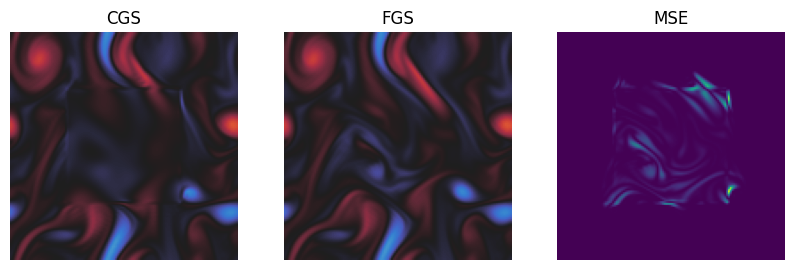

step=75
Correlation: 0.9698735876270129
MSE: 0.006254421403330296
NMSE: 0.009098587516984143


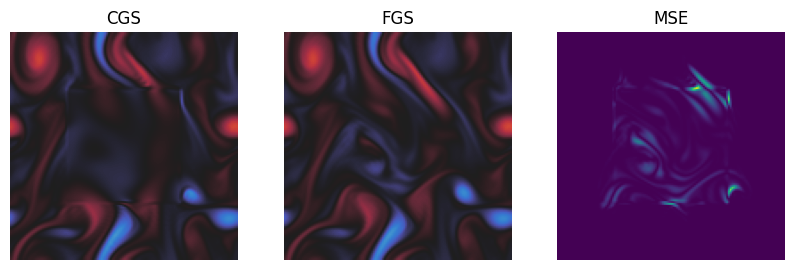

In [6]:
# play one episode and get the max and min vorticity value
obs, inf = env.reset()
alphas = np.ones(env.action_space.shape)
alphas[32:96, 32:96] = 0.92
maxs = []
mins = []
for i in range(100):
    if i%25==0:
        print(f"step={i}")
        env.render()
    #out = env.step(np.array([alphas]))
    out = env.step(alphas)
    obs = out[0]
    #print(obs)
    maxs.append(obs.max())
    mins.append(obs.min())
env.close()

step=0
Correlation: 1.0
MSE: 0.0
NMSE: 0.0


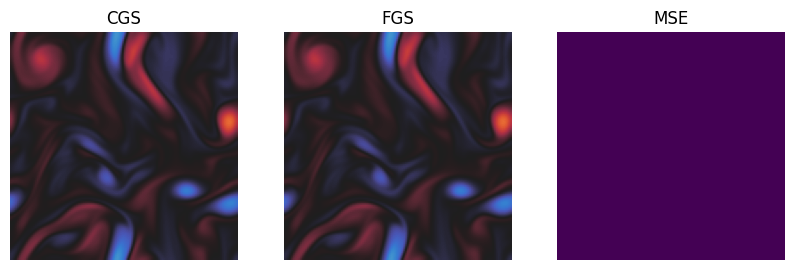

step=100
Correlation: 0.9640863667446604
MSE: 0.008742546378764872
NMSE: 0.012720367739535346


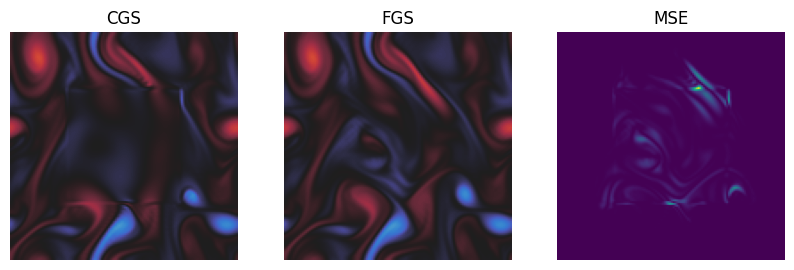

step=200
Correlation: 0.9229908476407197
MSE: 0.02710065640622441
NMSE: 0.037259741164760204


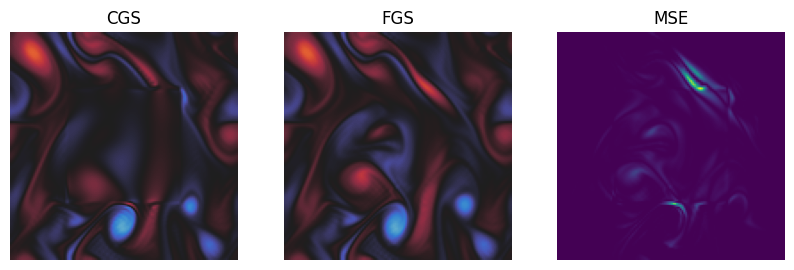

step=300
Correlation: 0.8561953279970064
MSE: 0.07036693654978467
NMSE: 0.0900113689638763


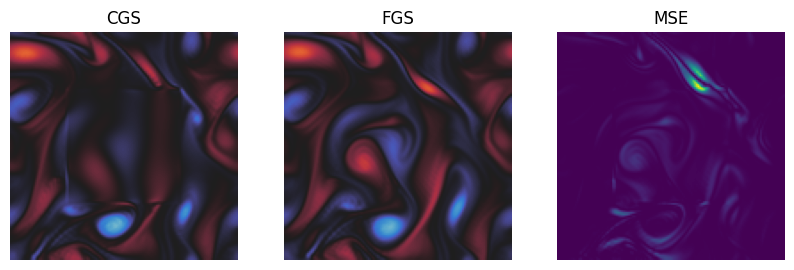

step=400
Correlation: 0.7169008593184827
MSE: 0.16930147143752355
NMSE: 0.20698536851041582


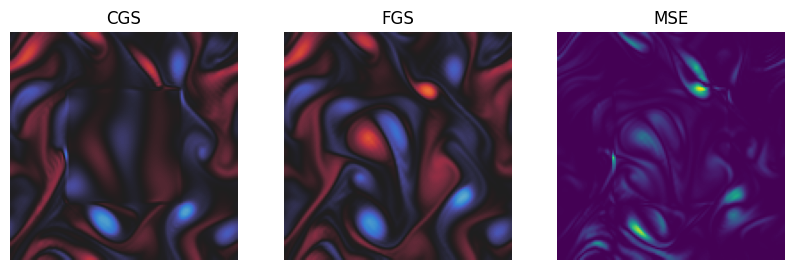

step=500
Correlation: 0.5875728186445051
MSE: 0.2828347845321845
NMSE: 0.3376805700747274


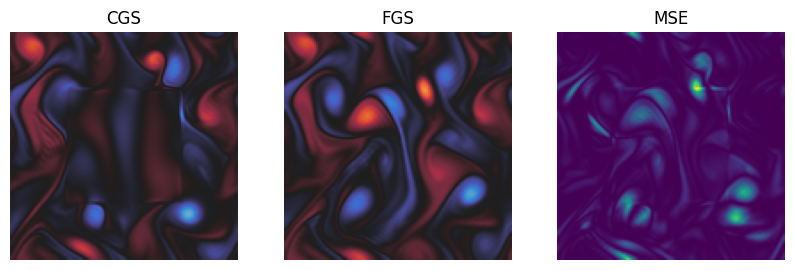

step=600
Correlation: 0.5438812967416964
MSE: 0.39986468529076835
NMSE: 0.4494356386656319


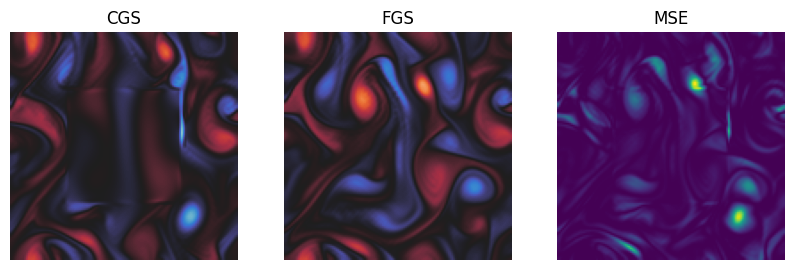

step=700
Correlation: 0.4277146796462741
MSE: 0.6053846511067308
NMSE: 0.6433008756159582


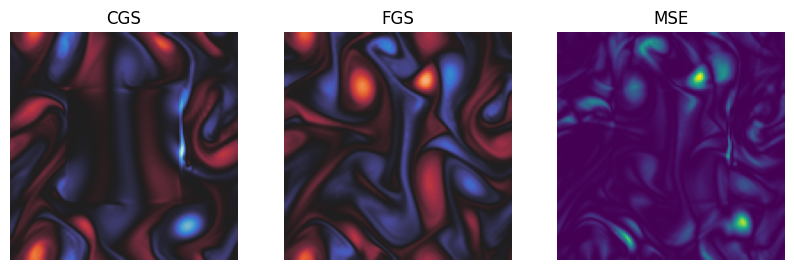

step=800
Correlation: 0.37252929877031776
MSE: 0.8553040302757011
NMSE: 0.844495999445902


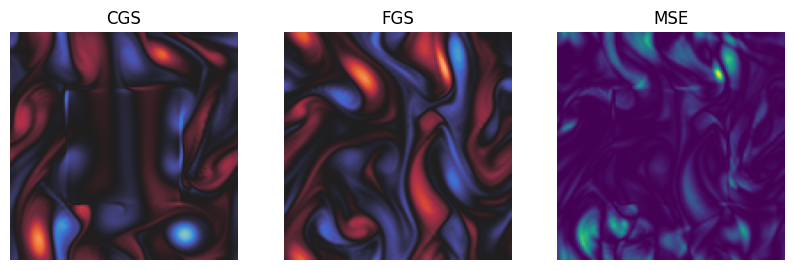

step=900
Correlation: 0.19418433518939623
MSE: 1.2425639902366208
NMSE: 1.1532190862011138


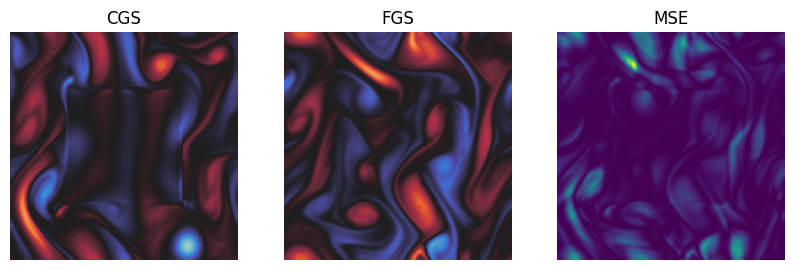

In [7]:
# play one episode and get the max and min vorticity value
obs, inf = env.reset()
alphas = np.ones(env.action_space.shape)
alphas[32:96, 32:96] = 0.92
maxs = []
mins = []
for i in range(1000):
    if i%100==0:
        print(f"step={i}")
        env.render()
    #out = env.step(np.array([alphas]))
    out = env.step(alphas)
    obs = out[0]
    #print(obs)
    maxs.append(obs.max())
    mins.append(obs.min())
env.close()

In [8]:
print(np.max(maxs))
print(np.min(mins))

3.08341102245838
-4.222932481657854


: 

# Levels of abstaction of Reinforce

In [7]:
#Policy
actor = MyFCNNActorProb(env.action_space.shape, device=device).to(device)
optim = torch.optim.AdamW(actor.parameters(), lr=0.0001)
dist = torch.distributions.Normal
policy = PGPolicy(model=actor,optim=optim, dist_fn=dist, action_space=env.action_space,
    discount_factor=0.97,reward_normalization=False, deterministic_eval=True,
    observation_space=env.observation_space, action_scaling=True, action_bound_method = "tanh",
)

#Collectors
train_collector = Collector(policy=policy,env=train_env,buffer=VectorReplayBuffer(20000, len(train_env)))
test_collector = Collector(policy=policy, env=test_env)
train_collector.reset()
test_collector.reset()

#Trainer
trainer = OnpolicyTrainer(policy=policy, train_collector=train_collector, test_collector=test_collector,
    max_epoch=2, step_per_epoch=100, repeat_per_collect=1, episode_per_test=1, batch_size=16,
    episode_per_collect=1, show_progress=True #stop_fn=lambda mean_reward: mean_reward >= -200,
)

bias is initialized to Parameter containing:
tensor([0.2500], requires_grad=True)


In [8]:
#load trained bolicy
policy.load_state_dict(torch.load('dump/global_omega_local_acts.pth'))

<All keys matched successfully>

## Play one episode

-0.17589022 0.99268156 -0.17589022 0.98258996
0.998805428448291


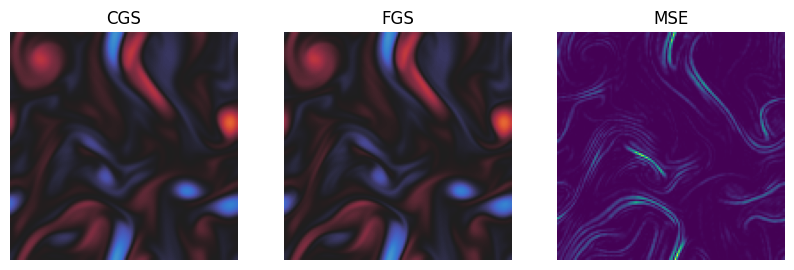

-0.17589022 0.99268156 -0.17589022 0.98258996
0.9966322573855615


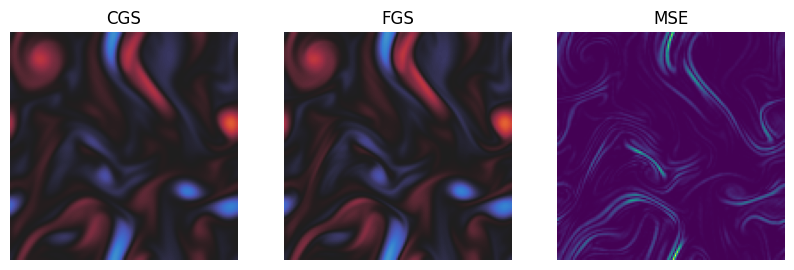

-0.17589022 0.99268156 -0.17589022 0.98258996
0.9942731648531313


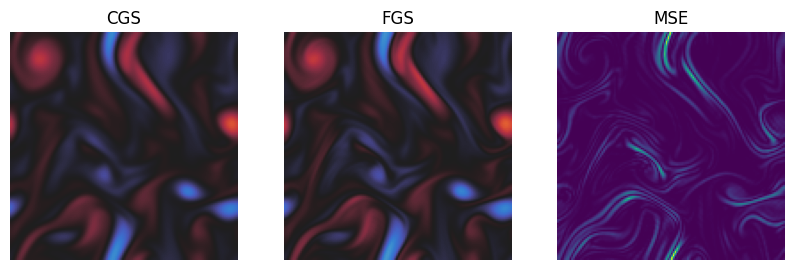

-0.17589022 0.99268156 -0.17589022 0.98258996
0.99177131864466


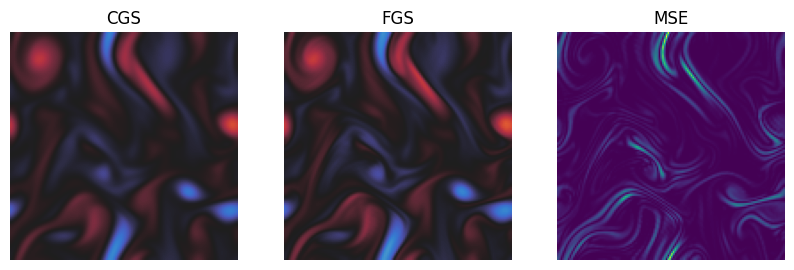

-0.17589022 0.99268156 -0.17589022 0.98258996
0.9891945014867467


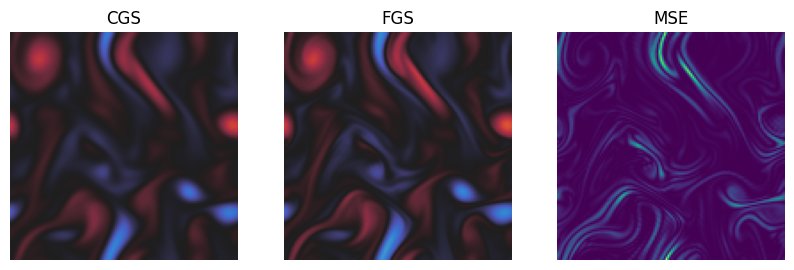

-0.17589022 0.99268156 -0.17589022 0.98258996
0.986460598318396


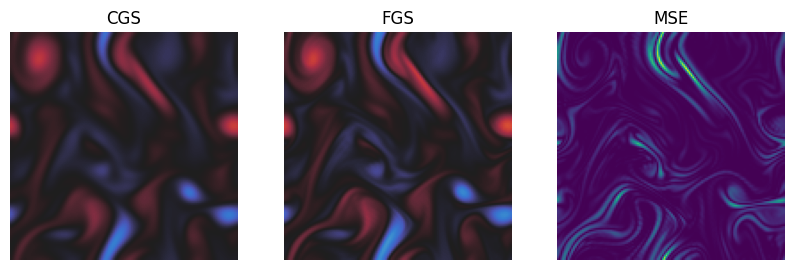

-0.17589022 0.99268156 -0.17589022 0.98258996
0.9836008793355667


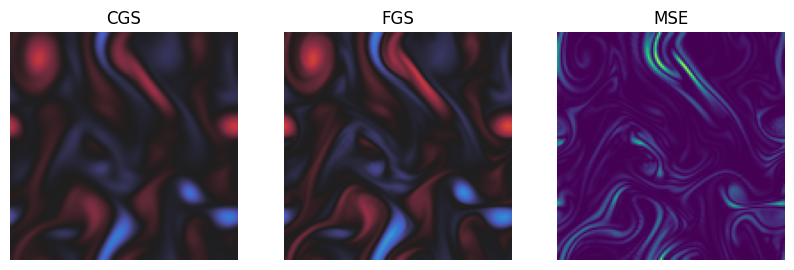

-0.17589022 0.99268156 -0.17589022 0.98258996
0.9805937318307103


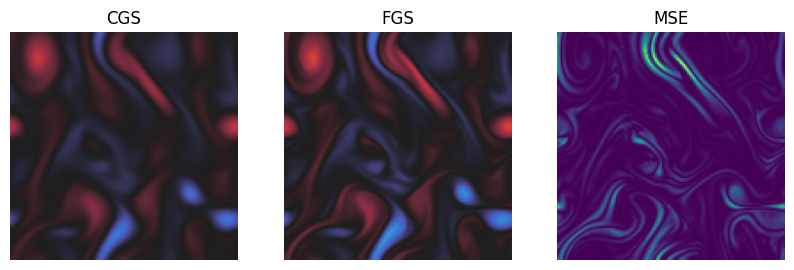

-0.17589022 0.99268156 -0.17589022 0.98258996
0.9775615472509719


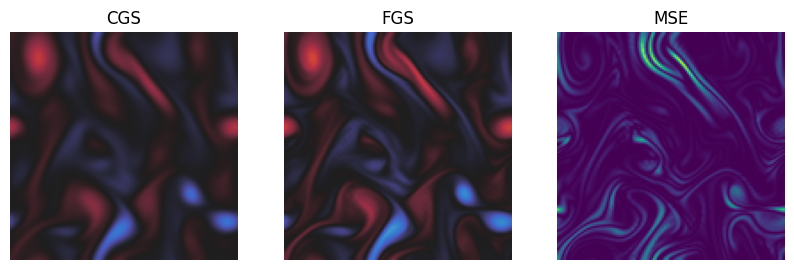

-0.17589022 0.99268156 -0.17589022 0.98258996
0.974464186395857


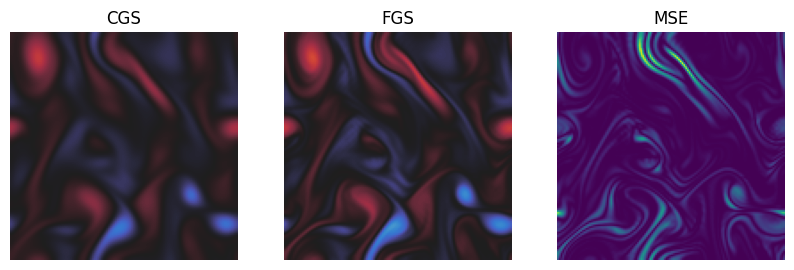

truncated
#steps = 101, Total Reward = 61.83784151046231


In [11]:
# just plays one episode
reward = 0
step = 0
policy.eval()
obs ,inf = env.reset()
actions = []
episode_is_over = False
while not episode_is_over:
    batch = policy(Batch(obs=np.array([obs]), info=inf))
    logits = batch.logits.detach().cpu().numpy()
    action = batch.act[0].detach().cpu().numpy()
    act = policy.map_action(action)
    actions.append(act[0])
    #print(logits, action, act)
    obs, rew, terminated, truncated, inf = env.step(act)
    reward += rew
    step += 1
    if step%10==0:
        #print(f"step: {step}, actual_steps: {env.counter}, action: {act}")
        print(logits[0].mean(), logits[1].mean(), action.mean(), act.mean())
        env.render()
    if terminated or truncated:
        if terminated:
             print("terminated")
        else:
            print("truncated")
        episode_is_over = True

print(f"#steps = {step}, Total Reward = {reward}")
env.close()

In [ ]:
# visualize policy

-0.17589022 0.99268156 -0.17589022 0.98258996
0.998805428448291


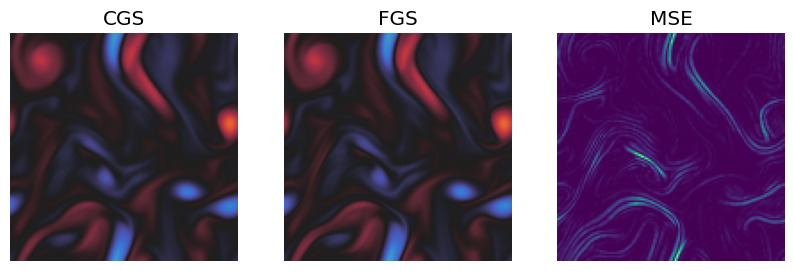

-0.17589022 0.99268156 -0.17589022 0.98258996
0.9966322573855615


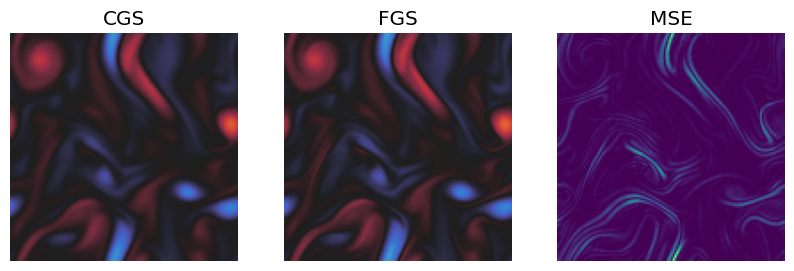

-0.17589022 0.99268156 -0.17589022 0.98258996
0.9942731648531313


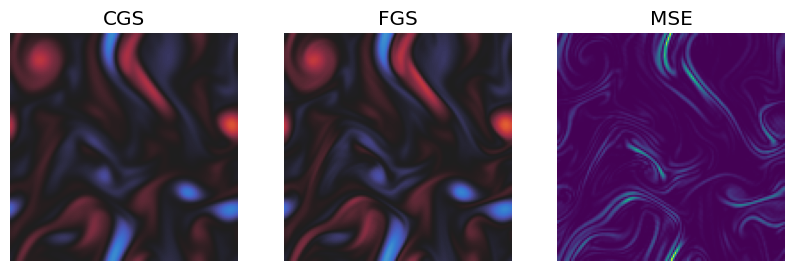

-0.17589022 0.99268156 -0.17589022 0.98258996
0.99177131864466


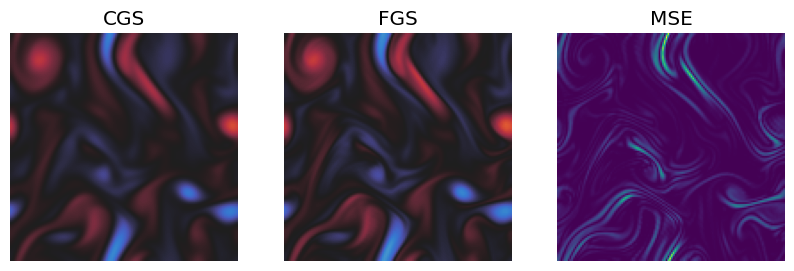

-0.17589022 0.99268156 -0.17589022 0.98258996
0.9891945014867467


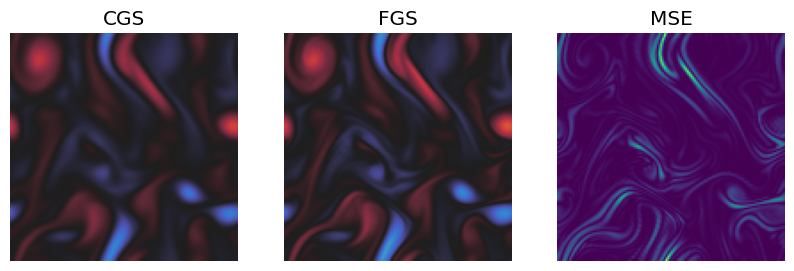

-0.17589022 0.99268156 -0.17589022 0.98258996
0.986460598318396


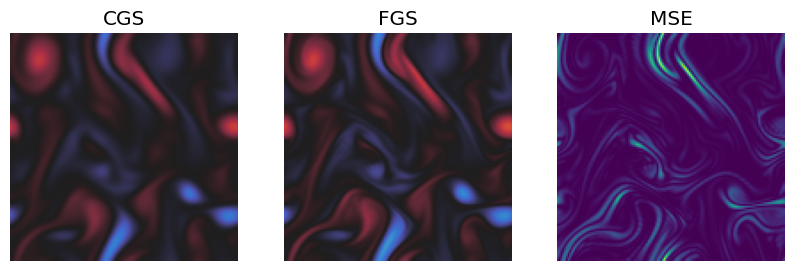

-0.17589022 0.99268156 -0.17589022 0.98258996
0.9836008793355667


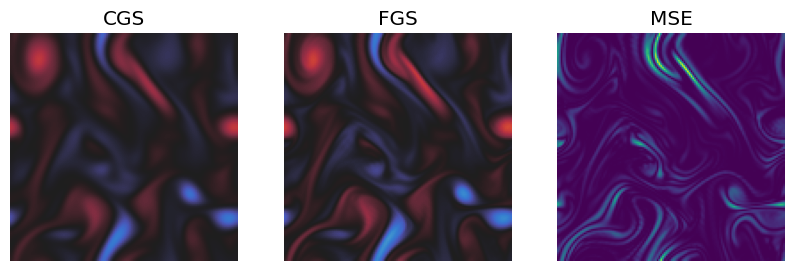

-0.17589022 0.99268156 -0.17589022 0.98258996
0.9805937318307103


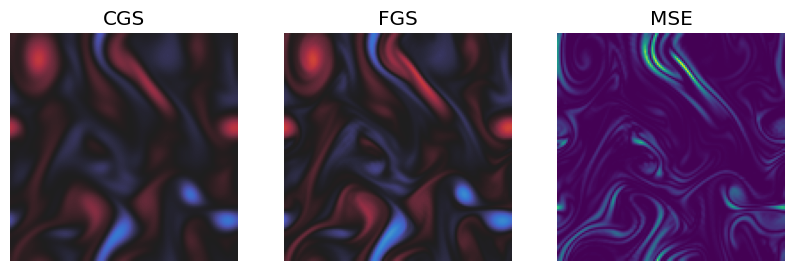

-0.17589022 0.99268156 -0.17589022 0.98258996
0.9775615472509719


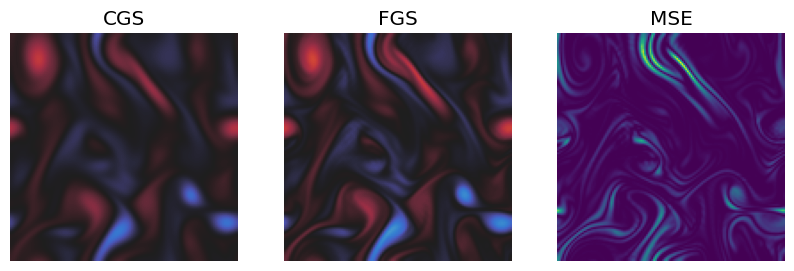

-0.17589022 0.99268156 -0.17589022 0.98258996
0.974464186395857


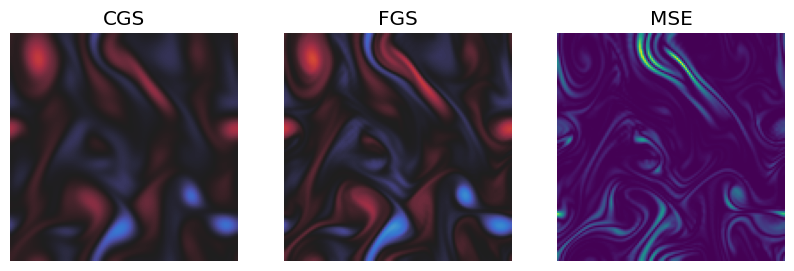

truncated
#steps = 101, Total Reward = 61.83784151046231


In [29]:
# just plays one episode
reward = 0
step = 0
policy.eval()
obs ,inf = env.reset()
act_means = []
act_maxs = []
act_mins = []
episode_is_over = False
while not episode_is_over:
    batch = policy(Batch(obs=np.array([obs]), info=inf))
    logits = batch.logits.detach().cpu().numpy()
    action = batch.act[0].detach().cpu().numpy()
    act = policy.map_action(action)
    act_means.append(logits[0].reshape(128,128).mean())
    act_mins.append(logits[0].reshape(128,128).min())
    act_maxs.append(logits[0].reshape(128,128).max())
    #print(logits, action, act)
    obs, rew, terminated, truncated, inf = env.step(act)
    reward += rew
    step += 1
    if step%10==0:
        #print(f"step: {step}, actual_steps: {env.counter}, action: {act}")
        print(logits[0].mean(), logits[1].mean(), action.mean(), act.mean())
        env.render()
    if terminated or truncated:
        if terminated:
             print("terminated")
        else:
            print("truncated")
        episode_is_over = True

print(f"#steps = {step}, Total Reward = {reward}")
env.close()

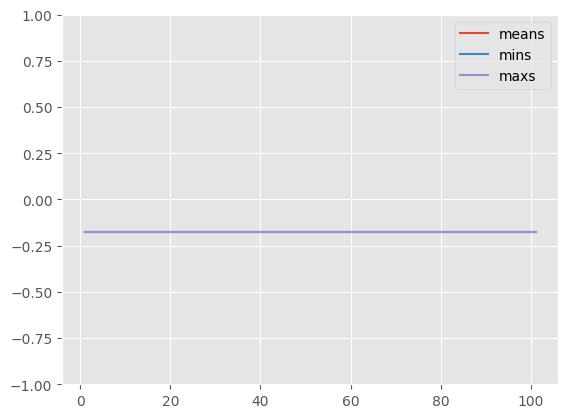

In [33]:
#this plots the mean, max and min of actions computed over space as a plot over the time of one episode
t = np.linspace(1, len(act_means),len(act_means))
plt.figure()
plt.plot(t, act_means, label="means")
plt.plot(t, act_mins, label="mins")
plt.plot(t, act_maxs, label="maxs")
plt.ylim([-1,1])
plt.legend()
plt.show()

In [23]:
obs, inf = env.reset()
mean, std = policy(Batch(obs=np.array([obs]), info={})).logits.detach().cpu().numpy()
mean, std = mean.reshape(128,128), std.reshape(128,128)

(128, 128)

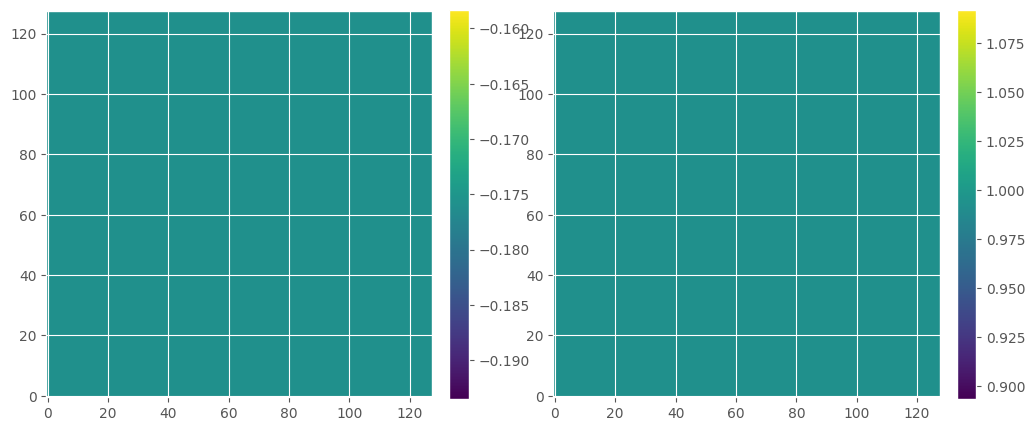

In [26]:
plt.style.use('ggplot')
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
im1 = axs[0].imshow(mean, cmap='viridis', aspect='equal', origin='lower')
im2 = axs[1].imshow(std, cmap='viridis', aspect='equal', origin='lower')
cbar1 = fig.colorbar(im1, ax=axs[0], fraction=0.046, pad=0.04)
cbar2 = fig.colorbar(im2, ax=axs[1], fraction=0.046, pad=0.04)
plt.show()

In [ ]:
env.close()
test_env.close()
train_env.close()
trainer.reset()